# Tully-Fisher Relation of galaxies

For all galaxies in Iron (Y1) which have valid rotational velocities at $0.4R_{26}$, plot their TFR.  Also include the best-fit TFR (as calibrated using `TF_Y1_cluster_calibration_AnthonyUpdates2_weightsVmax-1_KAD.ipynb`).

In [1]:
from astropy.table import Table, join
from astropy.cosmology import Planck18, LambdaCDM, FlatLambdaCDM
from astropy.io import fits
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

import numpy as np

from scipy.stats import binned_statistic

import pickle

import os

import matplotlib.pyplot as plt

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
h = 1
H0 = 100*h

c = const.c.to('km/s')

q0 = 0.2

# Data

In [3]:
# SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_VI.fits')
# SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
SGA_TF = Table.read('SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.365240555641251e-05,122.3223893029039,9.671537005812278,N
55,SGA-2020 55,PGC1203947

## Morphologies

Do our results improve if we only consider spiral and irregular galaxies?

In [4]:
ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other


In [5]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [6]:
SGA_TF = join(SGA_TF, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
SGA_TF['Predicted_Type'].name = 'MORPHTYPE_AI'

In [7]:
SGA_TF['SGA_ID', 'MORPHTYPE_AI'][:5]

SGA_ID,MORPHTYPE_AI
float64,str10
38.0,Spiral
55.0,Irregular
117.0,Spiral
223.0,Irregular
581.0,--


## John's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We will also remove any galaxies that John identified as having significant asymmetry, double galaxies, or stellar contamination.

In [8]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [9]:
SGA_TF = join(SGA_TF, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
SGA_TF['VI'].name = 'JOHN_VI'

## Convert to CMB frame

In [10]:
SGA_TF['Z_DESI_CMB'] = convert_z_frame(SGA_TF['Z_DESI'], SGA_TF['RA'], SGA_TF['DEC'])

## Photometric corrections

### Survey offsets

In [11]:
sys_corr, sys_corr_err = BASS_corr(SGA_TF['PHOTSYS'])

### MW Dust corrections

In [12]:
# Import E(B-V) dust map
# ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [13]:
MWdust_corr, MWdust_corr_err = MW_dust(SGA_TF['RA'], SGA_TF['DEC'], ebv_map)

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [14]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [15]:
# Apparently we have some galaxies with negative redshifts
zg0 = SGA_TF['Z_DESI'] >= 0

In [16]:
kcorr_zg0 = k_corr(SGA_TF['Z_DESI'][zg0], 
                   [SGA_TF['G_MAG_SB26'][zg0], SGA_TF['R_MAG_SB26'][zg0], SGA_TF['Z_MAG_SB26'][zg0]], 
                   [SGA_TF['G_MAG_SB26_ERR'][zg0], SGA_TF['R_MAG_SB26_ERR'][zg0], SGA_TF['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # to match FastSpecFit / FP

In [17]:
kcorr = np.zeros([len(SGA_TF), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [18]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [19]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [20]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

### Apply corrections

In [21]:
SGA_TF['G_MAG_SB26_CORR'] = SGA_TF['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
SGA_TF['R_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
SGA_TF['Z_MAG_SB26_CORR'] = SGA_TF['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [22]:
SGA_TF['G_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
SGA_TF['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
SGA_TF['Z_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# TFR

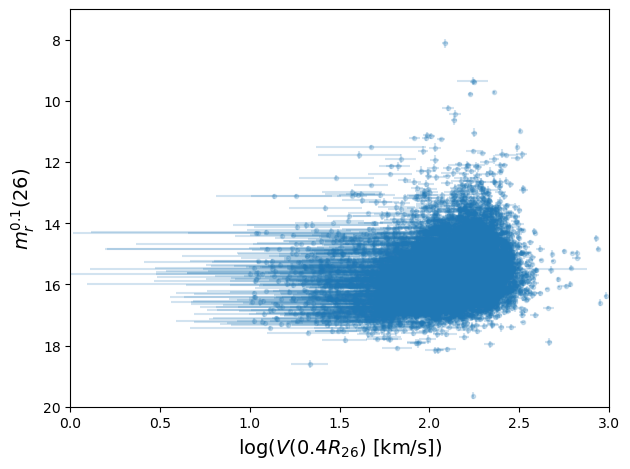

In [23]:
plt.figure(tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p4R26']), 
             SGA_TF['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR']/SGA_TF['V_0p4R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             alpha=0.2)

# plt.errorbar(np.log10(SGA_TF_corr['V_0p4R26']), 
#              SGA_TF_corr['R_MAG_SB26_CORR'], 
#              xerr=0.434*SGA_TF_corr['V_0p4R26_err']/SGA_TF_corr['V_0p4R26'],
#              yerr=SGA_TF_corr['R_MAG_SB26_CORR_ERR'], 
#              fmt='.', 
#              ecolor='bisque',
#              alpha=0.5)

plt.xlim([0, 3])
plt.ylim([20, 7])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$m_r^{0.1} (26)$', fontsize=14);

# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box');

## Compute the absolute magnitudes based on the redshift

In [24]:
cosmo = LambdaCDM(H0=H0, 
                  Om0=Planck18.Om0, 
                  Tcmb0=Planck18.Tcmb0, 
                  Neff=Planck18.Neff, 
                  m_nu=Planck18.m_nu, 
                  Ob0=Planck18.Ob0, 
                  Ode0=Planck18.Ode0)
SGA_TF['MU_ZCMB'] = cosmo.distmod(SGA_TF['Z_DESI_CMB'])

SGA_TF['R_ABSMAG_SB26'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['MU_ZCMB'].value

In [25]:
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(SGA_TF['MU_ZCMB']))*u.mag

for i in tqdm(range(len(mu_err))):
    
    z_desi_random = rng.normal(np.abs(SGA_TF['Z_DESI_CMB'][i]), 
                               SGA_TF['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    
    mu_err[i] = np.std(mu_random)

SGA_TF['MU_ZCMB_ERR'] = mu_err

SGA_TF['R_ABSMAG_SB26_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['MU_ZCMB_ERR'].value**2)

100%|████████████████████████████████████| 10262/10262 [00:37<00:00, 270.80it/s]


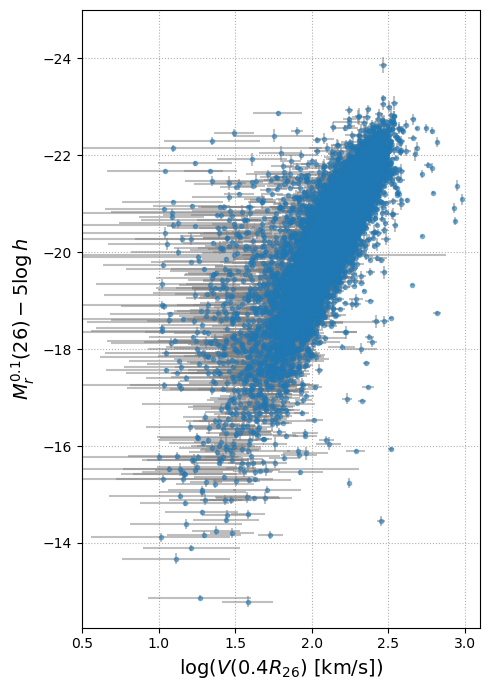

In [26]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

plt.errorbar(np.log10(SGA_TF['V_0p4R26']), 
             SGA_TF['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR']/SGA_TF['V_0p4R26'],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'], 
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -25])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box');

## Plotted with our TFR

In [27]:
logv = np.linspace(-1, 3.5, 100)

### Calibration without dwarfs

Here, $V_0$, the slope, and the y-intercept are from `TF_Y1_cluster_calibration_AnthonyUpdates2_weightsVmax-1_KAD.ipynb`:

\begin{equation}
  M_r = a (\log(V(0.4R_{26})) - V_0) + b
\end{equation}

In [28]:
temp_infile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_Anthony2_weightsVmax-1_dVsys_KAD-20250717.pickle', 'rb')
cov_ab, tfr_samples, V0 = pickle.load(temp_infile)
temp_infile.close()

In [29]:
slope = np.median(tfr_samples[0])
slope_err = np.sqrt(cov_ab[0,0])

ZP = np.median(tfr_samples[1])
ZP_err = np.sqrt(cov_ab[1,1])

sig = np.median(tfr_samples[-1])

absmag = slope*(logv - V0) + ZP

In [30]:
# Calculate the uncertainties in the calibrated TFR
slopes = tfr_samples[0]
ZPs = tfr_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - V0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

In [31]:
logV_n17 = (-17 + 5*np.log10(h) - ZP)/slope + V0
b_perp = -17 + 5*np.log10(h) + (1/slope)*(logV_n17 - V0)

dwarf_boolean = (SGA_TF['R_ABSMAG_SB26'] - SGA_TF['R_ABSMAG_SB26_ERR']) > (-(np.log10(SGA_TF['V_0p4R26']) - V0)/slope + b_perp)

print(10**(logV_n17), 'km/s')

40.23839149435922 km/s


In [32]:
spiral_boolean = SGA_TF['MORPHTYPE_AI'] == 'Spiral'
irregular_boolean = SGA_TF['MORPHTYPE_AI'] == 'Irregular'
# other_boolean = SGA_TF['MORPHTYPE_AI'] == 'Other'

VI_boolean = SGA_TF['JOHN_VI'].mask

morph_boolean = (spiral_boolean | irregular_boolean) & VI_boolean

In [33]:
SGA_TF['DWARF'] = dwarf_boolean
SGA_TF['GOOD_MORPH'] = morph_boolean

print(sum(dwarf_boolean), 'dwarfs')
print(len(SGA_TF) - sum(dwarf_boolean), 'non-dwarfs')
print('-----------')
print(np.sum(morph_boolean), 'spirals & irregulars that pass VI')
print(np.sum(morph_boolean & dwarf_boolean), 'dwarfs')
print(np.sum(morph_boolean & ~dwarf_boolean), 'non-dwarfs')

# print(sum(dwarf_boolean_corr), 'dwarfs')
# print(len(SGA_TF_corr) - sum(dwarf_boolean_corr), 'non-dwarfs')

179 dwarfs
10083 non-dwarfs
-----------
9264 spirals & irregulars that pass VI
153 dwarfs
9111 non-dwarfs


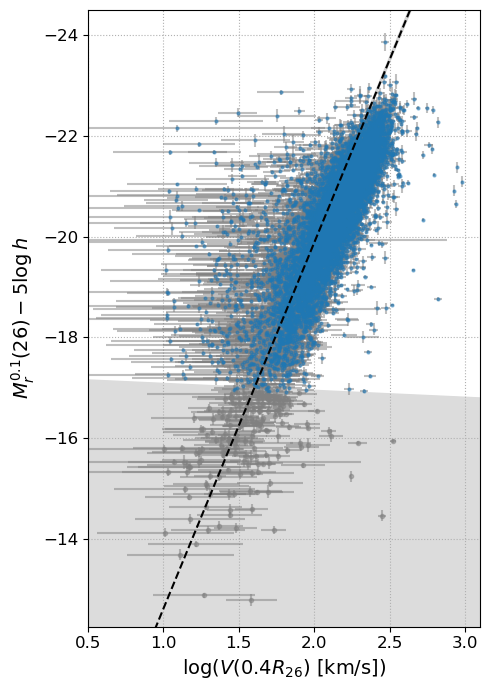

In [34]:
yvals_perp = -(logv - V0)/slope + b_perp

plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = ~dwarf_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             alpha=0.5, 
             ecolor='gray')
sample = dwarf_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')
'''
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][~dwarf_boolean & ~morph_boolean]), 
             SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean & ~morph_boolean], 
             # xerr=0.434*SGA_TF['V_0p4R26_ERR'][~dwarf_boolean & ~morph_boolean]/SGA_TF['V_0p4R26'][~dwarf_boolean & ~morph_boolean],
             # yerr=SGA_TF['R_ABSMAG_SB26_ERR'][~dwarf_boolean & ~morph_boolean], 
             fmt='x', 
             # color='tab:orange',
             markersize=4, 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][dwarf_boolean & ~morph_boolean]), 
             SGA_TF['R_ABSMAG_SB26'][dwarf_boolean & ~morph_boolean], 
             # xerr=0.434*SGA_TF['V_0p4R26_ERR'][dwarf_boolean & ~morph_boolean]/SGA_TF['V_0p4R26'][dwarf_boolean & ~morph_boolean],
             # yerr=SGA_TF['R_ABSMAG_SB26_ERR'][dwarf_boolean & ~morph_boolean], 
             fmt='x',
             color='tab:orange',
             alpha=0.5, 
             ecolor='gray')
'''
plt.plot(logv, absmag, 'k--', zorder=3)

# plt.plot(logv, yvals_perp, 'r:')
plt.fill_between(logv, yvals_perp, -12, color='gainsboro')

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);
# ax.set_aspect('equal', adjustable='box');

# plt.savefig('../../Figures/Y1/iron_jointTFR_varyV0-perpdwarf_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none')

The vertical shift between the galaxies and the calibrated TFR is expected, as this is due to the $5\log h$ term.

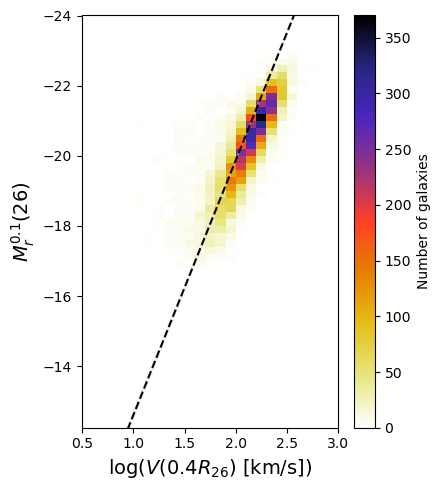

In [35]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hist2d(np.log10(SGA_TF['V_0p4R26'][~dwarf_boolean]), 
           SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean], 
           bins=[np.arange(0.5,3.1,0.1), np.arange(-24, -11.9, 0.2)], 
           cmap='CMRmap_r')
plt.colorbar(label='Number of galaxies')

plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([0.5, 3])
plt.ylim([-12.25, -24])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26)$', fontsize=14);

#### Redshift distribution

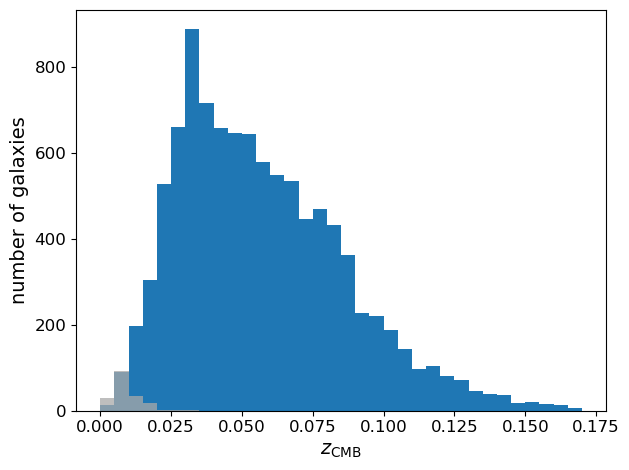

In [36]:
plt.figure(tight_layout=True)

plt.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean],
         bins=np.arange(0, 0.175, 0.005))
plt.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean],
         bins=np.arange(0, 0.175, 0.005), 
         color='darkgray',
         alpha=0.75)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

# Distance moduli

In [37]:
SGA_TF['R_ABSMAG_SB26_TF'] = slope*(np.log10(SGA_TF['V_0p4R26']) - V0) + ZP

In [38]:
SGA_TF['R_ABSMAG_SB26_TF_ERR'] = np.nan
SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(SGA_TF))):
    
    v_random = rng.normal(SGA_TF['V_0p4R26'][i], 
                          SGA_TF['V_0p4R26_ERR'][i], 
                          size=len(slopes))
    # logv_random = rng.normal(np.log10(SGA_TF['V_0p4R26'][i]), 
    #                          0.434*SGA_TF['V_0p4R26_ERR'][i]/SGA_TF['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = slope*(np.log10(v_random[v_random > 0]) - V0) + ZP
    # Ms_stat = slope*(logv_random - V0) + ZP

    SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################


    # plt.figure(tight_layout=True)
    # plt.subplot(121)
    # plt.hist(np.log10(v_random[v_random > 0]), bins=100)
    # plt.xlabel('log(V)')
    # plt.title('log($\sigma_v) =$ {:.2f}'.format(np.log10(SGA_TF['V_0p4R26_ERR'][i])))
    # plt.subplot(122)
    # plt.hist(Ms_stat, bins=100)
    # plt.xlabel('$\sigma_{M_r}$ (stat)')
    # plt.title('$\sigma_M =$ {:.2f}'.format(SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][i]))
    # plt.show();


    ############################################################################
    # Total uncertainty
    #---------------------------------------------------------------------------
    Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    SGA_TF['R_ABSMAG_SB26_TF_ERR'][i] = np.sqrt(np.nanstd(Ms)**2 + sig**2)
    ############################################################################


################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
SGA_TF['R_ABSMAG_SB26_TF_ERR_SYS'] = np.sqrt(SGA_TF['R_ABSMAG_SB26_TF_ERR']**2 - SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT']**2)
################################################################################

100%|█████████████████████████████████████| 10262/10262 [02:04<00:00, 82.75it/s]


In [39]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

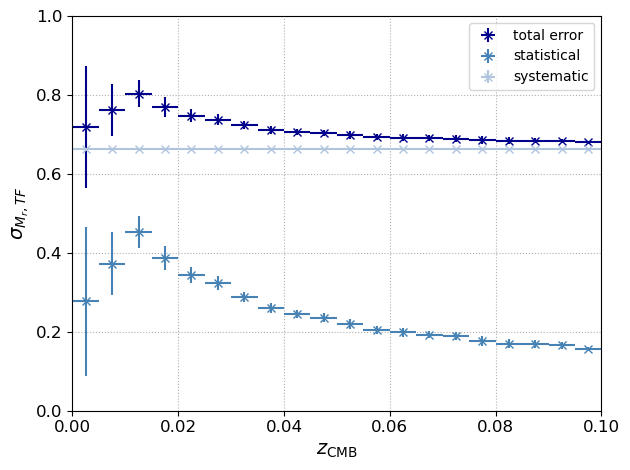

In [42]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

# plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], '.', alpha=0.1)

# Total uncertainty
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_ABSMAG_SB26_TF_ERR'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='total error')

# Statistical uncertainty (just from velocity uncertainty)
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='steelblue', label='statistical')

# Systematic uncertainty (from TF calibration)
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_ABSMAG_SB26_TF_ERR_SYS'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='systematic')

plt.grid(ls=':')

plt.legend()

plt.xlim(0, 0.1)
plt.ylim(0, 1)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_{M_r, TF}$', fontsize=14);

## Compute distance modulus based on our TFR

In [43]:
SGA_TF['MU_TF'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['R_ABSMAG_SB26_TF']

SGA_TF['MU_TF_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['R_ABSMAG_SB26_TF_ERR']**2)
# SGA_TF['mu_TF_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['R_ABSMAG_SB26_TF_err']**2 + sig**2)

## $\Delta M_r$ v. redshift

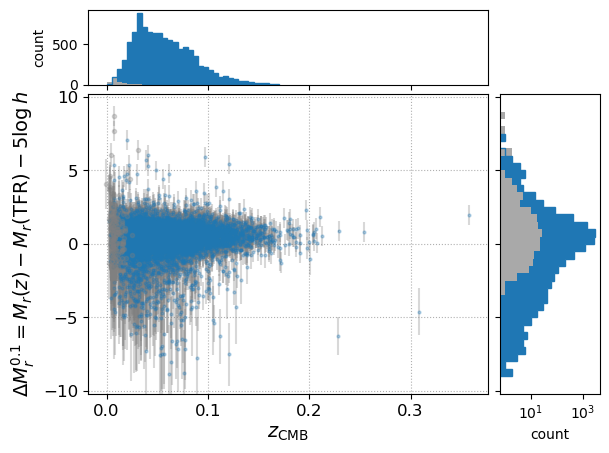

In [44]:
fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
sample = ~dwarf_boolean
ax.errorbar(SGA_TF['Z_DESI_CMB'][sample], 
             SGA_TF['R_ABSMAG_SB26'][sample] - SGA_TF['R_ABSMAG_SB26_TF'][sample], 
             xerr=SGA_TF['ZERR_DESI'][sample], 
             yerr=SGA_TF['MU_TF_ERR'][sample],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')
sample = dwarf_boolean# & morph_boolean
ax.errorbar(SGA_TF['Z_DESI_CMB'][sample], 
             SGA_TF['R_ABSMAG_SB26'][sample] - SGA_TF['R_ABSMAG_SB26_TF'][sample], 
             xerr=SGA_TF['ZERR_DESI'][sample], 
             yerr=SGA_TF['MU_TF_ERR'][sample],
             fmt='.', 
             color='gray',
             alpha=0.3, 
             ecolor='gray')

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\Delta M_r^{0.1} = M_r(z) - M_r(\text{TFR}) - 5\log h$', fontsize=14)

ax.set_ylim((-10.2, 10.2))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean],
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
sample1 = ~dwarf_boolean
sample2 = dwarf_boolean
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][sample1] - SGA_TF['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][sample2] - SGA_TF['R_ABSMAG_SB26_TF'][sample2], 
              bins=np.arange(-12.5, 10, 0.5), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][sample1] - SGA_TF['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

## $\eta$ v. redshift

In [45]:
SGA_TF['LOGDIST'] = 0.2*(SGA_TF['MU_ZCMB'] - SGA_TF['MU_TF'])
SGA_TF['LOGDIST_ERR'] = 0.2*np.sqrt(SGA_TF['MU_ZCMB_ERR']**2 + SGA_TF['MU_TF_ERR']**2)

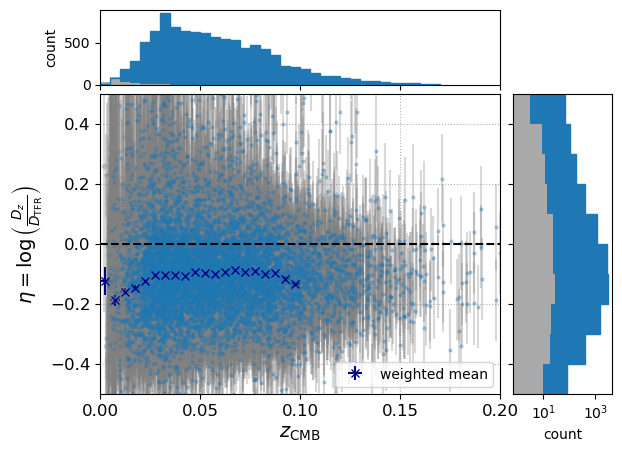

In [52]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean & VI_boolean
sample2 = dwarf_boolean

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax.errorbar(SGA_TF['Z_DESI_CMB'][sample1], 
             SGA_TF['LOGDIST'][sample1], 
             xerr=SGA_TF['ZERR_DESI'][sample1], 
             yerr=SGA_TF['LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][sample2], 
             SGA_TF['LOGDIST'][sample2], 
             xerr=SGA_TF['ZERR_DESI'][sample2], 
             yerr=SGA_TF['LOGDIST_ERR'][sample2],
             fmt='.', 
             color='gray',
             alpha=0.3, 
             ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=SGA_TF['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')
'''
# Plot the median
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')
'''
# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
ax.set_xlim((0, 0.2))
ax.set_ylim((-0.5, 0.5))
# ax.set_ylim((-0.2, 0))
# ax.set_xlim((0, 0.1))

ax.grid(ls=':')

ax.legend()


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

# plt.savefig('../../Figures/Y1/iron_logdist-v-z_jointTFR-varyV0-perpdwarfs_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

/var/folders/mg/fxh1s24d0n3_r0c39d3gs0g00000gq/T/ipykernel_3261/3818747994.py:50: RuntimeWarning: invalid value encountered in divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))


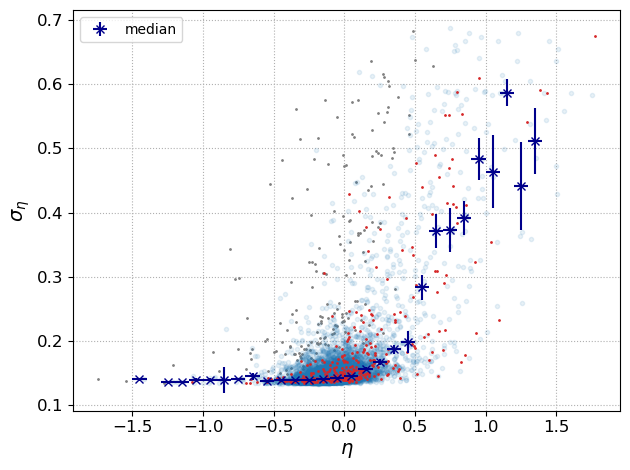

In [55]:
# Any correlation between eta and its uncertainty?
nbins = np.arange(-1.5, 1.5, 0.1)
dn = 0.5*np.diff(nbins)
nc = 0.5*(nbins[1:] + nbins[:-1])

sample1 = ~dwarf_boolean & VI_boolean
sample2 = dwarf_boolean
sample3 = ~dwarf_boolean & ~VI_boolean

plt.figure(tight_layout=True)

plt.plot(SGA_TF['LOGDIST'][sample2], 
         SGA_TF['LOGDIST_ERR'][sample2], 
         '.', c='gray', ms=2)

plt.plot(SGA_TF['LOGDIST'][sample1], 
         SGA_TF['LOGDIST_ERR'][sample1], 
         '.', alpha=0.1)

plt.plot(SGA_TF['LOGDIST'][sample3], 
         SGA_TF['LOGDIST_ERR'][sample3], 
         '.', c='tab:red', ms=2)

# Plot median
N, y_avg, y_std = profile_histogram(SGA_TF['LOGDIST'][sample1], 
                                    SGA_TF['LOGDIST_ERR'][sample1], 
                                    nbins, 
                                    median=True)
plt.errorbar(nc, y_avg, xerr=dn, yerr=y_std, fmt='x', color='darkblue', label='median')

plt.grid(ls=':')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$\eta$', fontsize=14)
plt.ylabel(r'$\sigma_\eta$', fontsize=14);

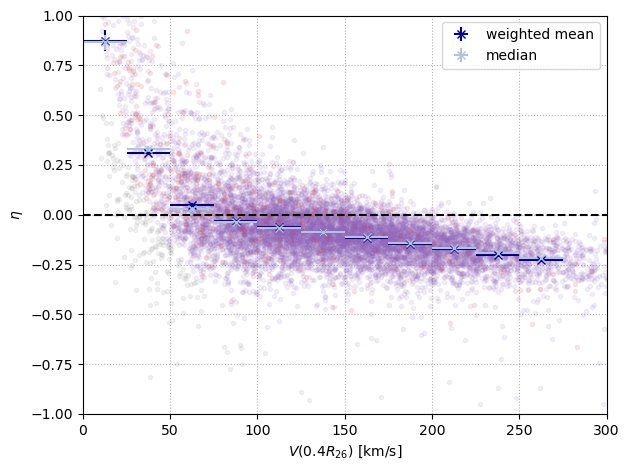

In [56]:
# logv_bins = np.arange(1.75, 2.5, 0.1)
logv_bins = np.arange(0, 300, 25) # These are really linear bins in V
dv = 0.5*np.diff(logv_bins)
vc = 0.5*(logv_bins[1:] + logv_bins[:-1])

plt.figure(tight_layout=True)

sample1 = ~dwarf_boolean & VI_boolean
sample2 = dwarf_boolean
sample3 = ~dwarf_boolean & ~VI_boolean

plt.grid(ls=':')

# plt.plot(np.log10(SGA_TF['V_0p4R26'][sample2]), 
plt.plot(SGA_TF['V_0p4R26'][sample2], 
         SGA_TF['LOGDIST'][sample2], 
         '.', alpha=0.1, c='gray')

# plt.plot(np.log10(SGA_TF['V_0p4R26'][sample1]), 
plt.plot(SGA_TF['V_0p4R26'][sample1], 
         SGA_TF['LOGDIST'][sample1], 
         '.', alpha=0.1, c='tab:purple')

# plt.plot(np.log10(SGA_TF['V_0p4R26'][sample3]), 
plt.plot(SGA_TF['V_0p4R26'][sample3], 
         SGA_TF['LOGDIST'][sample3], 
         '.', alpha=0.1, c='tab:red')

# Plot weighted mean
# _, y_avg, y_std = profile_histogram(np.log10(SGA_TF['V_0p4R26'][sample1]), 
_, y_avg, y_std = profile_histogram(SGA_TF['V_0p4R26'][sample1], 
                                    SGA_TF['LOGDIST'][sample1], 
                                    logv_bins, 
                                    weights=SGA_TF['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
plt.errorbar(vc, y_avg, xerr=dv, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')

# Plot median
# _, y_avg, y_std = profile_histogram(np.log10(SGA_TF['V_0p4R26'][sample1]), 
_, y_avg, y_std = profile_histogram(SGA_TF['V_0p4R26'][sample1], 
                                    SGA_TF['LOGDIST'][sample1], 
                                    logv_bins, 
                                    median=True)
plt.errorbar(vc, y_avg, xerr=dv, yerr=y_std, fmt='x', color='lightsteelblue', label='median')

plt.hlines(0, 0, 1000, colors='k', linestyles='dashed')

plt.legend()

plt.xlim(0, 300)
plt.ylim(-1, 1)

# plt.xlabel('log($V(0.4R_{26})$)')
plt.xlabel('$V(0.4R_{26})$ [km/s]')
plt.ylabel('$\eta$');

## Hubble diagram

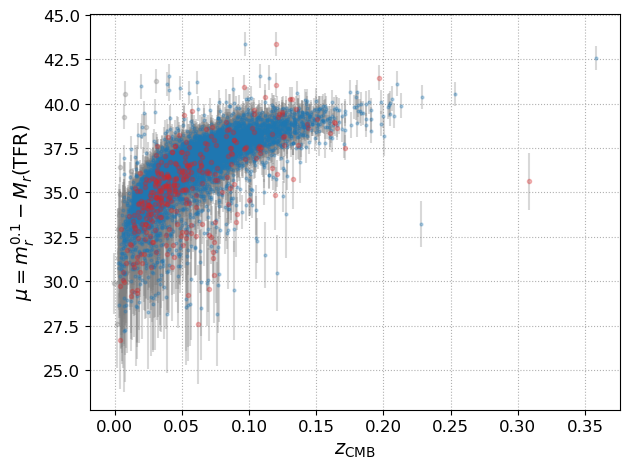

In [57]:
plt.figure(tight_layout=True)

sample = dwarf_boolean
plt.errorbar(SGA_TF['Z_DESI_CMB'][sample],
             SGA_TF['MU_TF'][sample],
             xerr=SGA_TF['ZERR_DESI'][sample],
             yerr=SGA_TF['MU_TF_ERR'][sample],
             fmt='.', 
             color='gray',
             alpha=0.3, 
             ecolor='gray')

sample = ~dwarf_boolean & VI_boolean
plt.errorbar(SGA_TF['Z_DESI_CMB'][sample],
             SGA_TF['MU_TF'][sample],
             xerr=SGA_TF['ZERR_DESI'][sample],
             yerr=SGA_TF['MU_TF_ERR'][sample],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

sample = ~dwarf_boolean & ~VI_boolean
plt.errorbar(SGA_TF['Z_DESI_CMB'][sample],
             SGA_TF['MU_TF'][sample],
             xerr=SGA_TF['ZERR_DESI'][sample],
             yerr=SGA_TF['MU_TF_ERR'][sample],
             fmt='.', 
             color='tab:red',
             alpha=0.3, 
             ecolor='gray')

plt.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\mu = m_r^{0.1} - M_r(\text{TFR})$', fontsize=14);

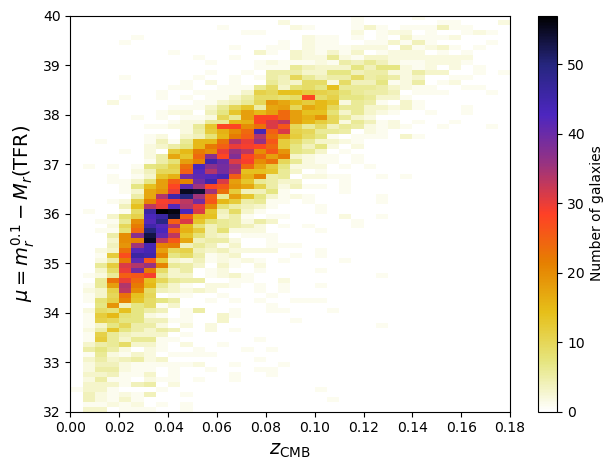

In [58]:
plt.figure(tight_layout=True)

plt.hist2d(SGA_TF['Z_DESI_CMB'][~dwarf_boolean & VI_boolean], 
           SGA_TF['MU_TF'][~dwarf_boolean & VI_boolean], 
           bins=[np.arange(0,0.35,0.005), np.arange(25, 43, 0.1)],
           cmap='CMRmap_r')
plt.colorbar(label='Number of galaxies')

plt.xlim([0, 0.18])
plt.ylim([32, 40])

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\mu = m_r^{0.1} - M_r(\text{TFR})$', fontsize=14);

## Save distance moduli to a file

In [46]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR1'
hdr['V_RADIUS'] = '0.4 R26'
hdr['M'] = slope
hdr['M_ERR'] = slope_err
hdr['0PT'] = ZP
hdr['0PT_ERR'] = ZP_err
hdr['V0'] = V0
hdr['SIG'] = sig
hdr['SIG_ERR'] = np.sqrt(cov_ab[-1,-1])
hdr['H0'] = H0

empty_primary = fits.PrimaryHDU(header=hdr)

In [47]:
table_hdu = fits.BinTableHDU(data=SGA_TF)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
hdul.writeto('SGA_iron_jointTFR-varyV0-perpdwarf_zCMB0p1_Anthony2_weightsVmax-1_dVsys_moduli.fits', 
             overwrite=True)